Using device: cpu
Starting Training...
Epoch [1/25] | Loss: 308.2772
Epoch [2/25] | Loss: 290.9004
Epoch [3/25] | Loss: 287.6840
Epoch [4/25] | Loss: 285.3230
Epoch [5/25] | Loss: 283.5524
Epoch [6/25] | Loss: 282.4202
Epoch [7/25] | Loss: 281.3977
Epoch [8/25] | Loss: 280.9098
Epoch [9/25] | Loss: 280.0756
Epoch [10/25] | Loss: 279.6772
Epoch [11/25] | Loss: 279.1424
Epoch [12/25] | Loss: 278.7048
Epoch [13/25] | Loss: 278.5854
Epoch [14/25] | Loss: 278.0569
Epoch [15/25] | Loss: 277.9563
Epoch [16/25] | Loss: 277.7576
Epoch [17/25] | Loss: 277.3374
Epoch [18/25] | Loss: 277.1956
Epoch [19/25] | Loss: 276.8158
Epoch [20/25] | Loss: 276.7882
Epoch [21/25] | Loss: 276.6400
Epoch [22/25] | Loss: 276.4291
Epoch [23/25] | Loss: 276.2198
Epoch [24/25] | Loss: 276.2272
Epoch [25/25] | Loss: 275.8709


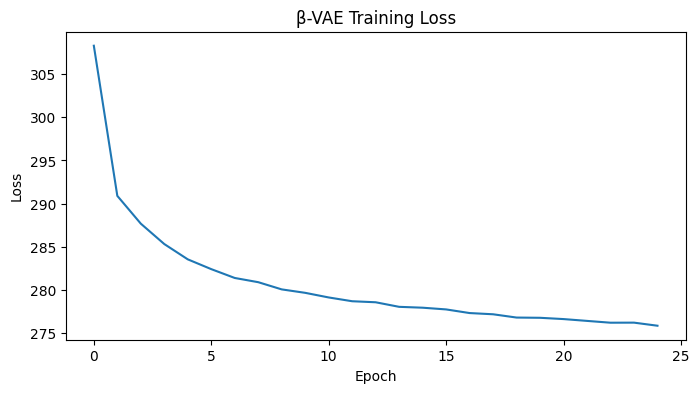

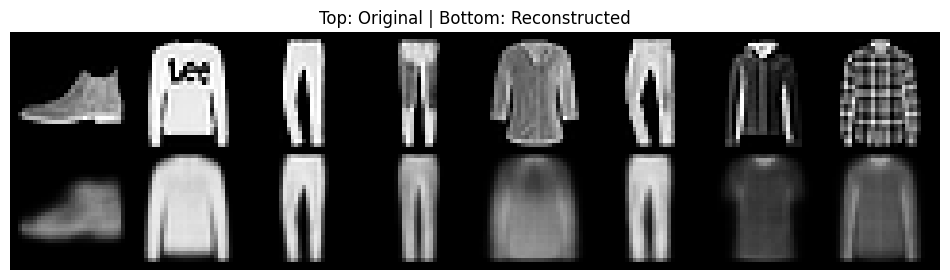

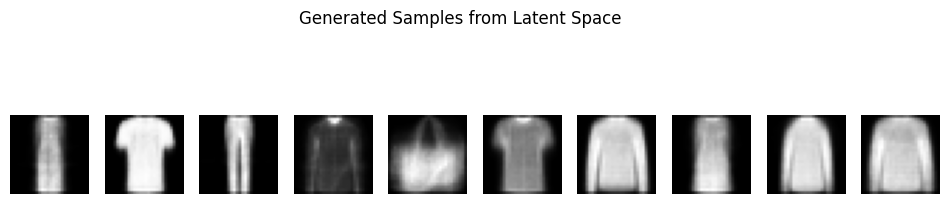

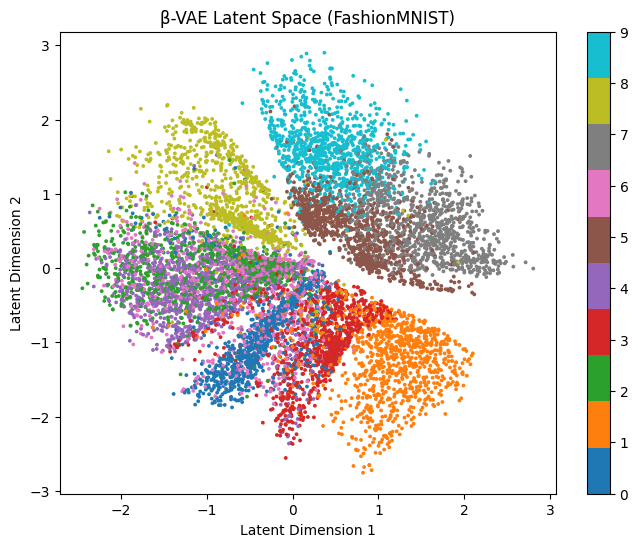

In [2]:
# -*- coding: utf-8 -*-
"""
Improved β-VAE on FashionMNIST
Unique, stable, and higher-quality implementation
"""

# ===============================
# Imports
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===============================
# Hyperparameters
# ===============================
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 25
LATENT_DIM = 2
BETA = 4.0   # β-VAE regularization

# ===============================
# Dataset
# ===============================
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===============================
# VAE Model
# ===============================
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        # -------- Encoder --------
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2)
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # -------- Decoder --------
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 784),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ===============================
# Loss Function (β-VAE)
# ===============================
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 784), reduction="sum"
    )

    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return BCE + BETA * KLD

# ===============================
# Training
# ===============================
model = VAE(LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f}")

# ===============================
# Plot Training Loss
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("β-VAE Training Loss")
plt.show()

# ===============================
# Visualization Functions
# ===============================
def visualize_reconstructions(model, loader, n=8):
    model.eval()
    data, _ = next(iter(loader))
    data = data[:n].to(device)

    with torch.no_grad():
        recon, _, _ = model(data)

    comparison = torch.cat([
        data.view(n, 1, 28, 28),
        recon.view(n, 1, 28, 28)
    ])

    grid = utils.make_grid(comparison, nrow=n)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.cpu().permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.title("Top: Original | Bottom: Reconstructed")
    plt.show()

def generate_samples(model, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, LATENT_DIM).to(device)
        samples = model.decode(z).view(n, 28, 28)

    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(samples[i].cpu(), cmap="gray")
        plt.axis("off")
    plt.suptitle("Generated Samples from Latent Space")
    plt.show()

def plot_latent_space(model, loader):
    model.eval()
    zs, labels = [], []

    with torch.no_grad():
        for data, y in loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            zs.append(mu.cpu())
            labels.append(y)

    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(zs[:, 0], zs[:, 1], c=labels, s=3, cmap="tab10")
    plt.colorbar()
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("β-VAE Latent Space (FashionMNIST)")
    plt.show()

# ===============================
# Run Visualizations
# ===============================
visualize_reconstructions(model, test_loader)
generate_samples(model)
plot_latent_space(model, test_loader)
